# **CNN with Pytorch:**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

Set the device for computation.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## **1. Load the data:**

In [3]:
train_data = datasets.MNIST(root = 'data',
                            train = True,
                            transform = ToTensor(),
                            download = True)
test_data = datasets.MNIST( root = 'data',
                            train = False,
                            transform = ToTensor(),
                            download = True)

### **Create the dataloaders**

In [4]:

loaders = {
    'train' : DataLoader(train_data, batch_size=32, shuffle=True, num_workers = 2),
    'test'  : DataLoader(test_data, batch_size=32, shuffle=True, num_workers = 2),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x222ec77c250>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x222ea6c8fd0>}

In [11]:
len(loaders['train'])

1875

### **Some example images:**

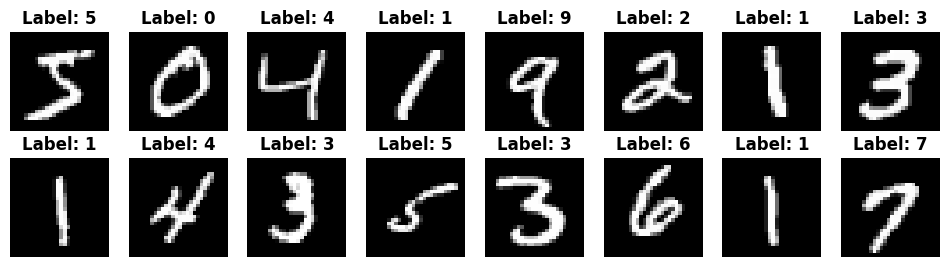

In [12]:
# Show the images
fig, axes = plt.subplots(2, 8, figsize=(12, 3))

for i in range(16):

    ax = axes[i // 8, i % 8]
    ax.imshow(train_data[i][0][0], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {train_data[i][1]}', fontweight = 'bold')
plt.show()

## **2. Modeling:**
### **Define CNN model:**

In [13]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Hidden layer 01
        self.conv1 = nn.Sequential(
            nn.Conv2d( in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1,),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
        )

        # Hidden layer 02
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.dropout_1 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.dense_1 = nn.Linear(3136, 128)
        self.dropout_2 = nn.Dropout(0.5)

        self.dense_2 = nn.Linear(128,10)
        self.log_softmax = nn.LogSoftmax(dim = 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout_1(x)
        x = self.flatten(x)
        x = self.dense_1(x)
        x = self.dropout_2(x)
        x = self.dense_2(x)
        output = self.log_softmax(x)
        return output

In [14]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout_1): Dropout(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense_1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout_2): Dropout(p=0.5, inplace=False)
  (dense_2): Linear(in_features=128, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


### **Define loss function:**

In [15]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

### **Define optimizer**

In [16]:
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### **Training process:**

In [17]:
num_epochs = 10
loss_list = []
iteration_list = []
accuracy_list = []

def train(num_epochs, cnn, loaders):
    cnn.train()
    # Train the model
    total_step = len(loaders['train'])

    for epoch in range(num_epochs):

        total_correct = 0
        total_samples = 0
        total_loss = 0

        for images, labels in loaders['train']:

            b_x = images.to(device)   # batch x
            b_y = labels.to(device)   # batch y

            # clear gradients for this training step
            optimizer.zero_grad()

            output = cnn(b_x)
            loss = loss_func(output, b_y)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(output.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            total_loss += loss.item()

        accuracy = total_correct / total_samples
        accuracy_list.append(accuracy)
        loss_list.append(total_loss)
        iteration_list.append(epoch)

        print(f"Epoch[{epoch}/{num_epochs}]. Accuracy: {accuracy}, Loss: {total_loss / len(loaders['train'])}")


In [18]:
start_time = time.time()
train(num_epochs, cnn, loaders)
end_time = time.time()

print(f"CNN training time with Pytorch: {end_time - start_time}")

Epoch[0/10]. Accuracy: 0.8589166666666667, Loss: 0.4502620596458515
Epoch[1/10]. Accuracy: 0.8939, Loss: 0.34096046442985534
Epoch[2/10]. Accuracy: 0.9025333333333333, Loss: 0.32347510523895423
Epoch[3/10]. Accuracy: 0.9058, Loss: 0.31410874585111936
Epoch[4/10]. Accuracy: 0.9082, Loss: 0.30528502577071387
Epoch[5/10]. Accuracy: 0.9047333333333333, Loss: 0.3148079745153586
Epoch[6/10]. Accuracy: 0.9039, Loss: 0.3184807828704516
Epoch[7/10]. Accuracy: 0.9048666666666667, Loss: 0.31656942857007186
Epoch[8/10]. Accuracy: 0.9072333333333333, Loss: 0.3104498915369312
Epoch[9/10]. Accuracy: 0.9029166666666667, Loss: 0.32334994881351786
CNN training time with Pytorch: 750.3159999847412


In [19]:
def test():
    # Test the model
    cnn.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images = images.to(device)   # batch x
            labels = labels.to(device)

            outputs = cnn(images)

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)

    accuracy = total_correct / total_samples
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.96


In [20]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [21]:
actual_number = lbls[:10].numpy()
actual_number

array([4, 5, 0, 5, 4, 1, 5, 3, 4, 2], dtype=int64)

In [22]:
test_output = cnn(imgs[:10])
_,pred_y = torch.max(test_output, 1)
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: tensor([4, 5, 0, 5, 4, 1, 5, 3, 4, 8])
Actual number: [4 5 0 5 4 1 5 3 4 2]
